In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!python3 -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 4.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15297, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 15297 (delta 7), reused 7 (delta 1), pack-reused 15275
Receiving objects: 100% (15297/15297), 6.18 MiB | 12.24 MiB/s, done.
Resolving deltas: 100% (11118/11118), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.4 MB/s eta 0:00:00
  Pre

In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [4]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

In [6]:
def get_sign_dicts(directory):
    classes = ['wind turbine', 'damaged wind turbine']
    dataset_dicts = []
    img_id = 0
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            # print('opened file')
            img_anns = json.load(f)
            # print(img_anns['images'])
            # print(img_anns['file_name'])

        record = {}
        temp = img_anns['imagePath'].split('\\')
    # print(temp[-1])
        filename = os.path.join(directory, temp[-1])
        # filename = os.path.join(directory, img_anns["imagePath"])

        record["file_name"] = filename
        record["image_id"] = img_id
        record["height"] = img_anns["imageHeight"]
        record["width"] = img_anns["imageWidth"]

        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
        img_id += 1
    return dataset_dicts


In [7]:
for d in ["train", "val"]:
    DatasetCatalog.register("wind_turbine_test1_" + d, lambda d=d: get_sign_dicts('/content/drive/MyDrive/wind_turbine_dataset/' + d))
    MetadataCatalog.get("wind_turbine_test1_" + d).set(thing_classes=['wind turbine','damaged wind turbine'])
wind_turbine_test1_metadata = MetadataCatalog.get("wind_turbine_test1_train")

In [8]:
dataset_dicts = get_sign_dicts("/content/drive/MyDrive/wind_turbine_dataset/train")

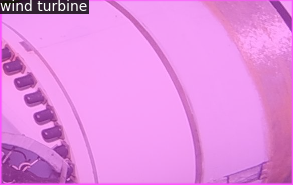

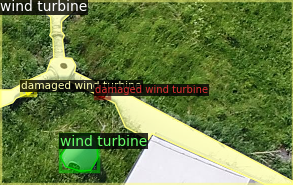

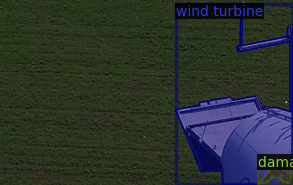

In [9]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=wind_turbine_test1_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [10]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("wind_turbine_test1_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/29 11:46:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 132MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[12/29 11:46:57 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/29 11:47:13 d2.utils.events]:  eta: 0:08:48  iter: 19  total_loss: 1.832  loss_cls: 0.8669  loss_box_reg: 0.143  loss_mask: 0.6859  loss_rpn_cls: 0.03607  loss_rpn_loc: 0.03174    time: 0.5952  last_time: 0.3672  data_time: 0.0294  last_data_time: 0.0057   lr: 4.9953e-06  max_mem: 2567M
[12/29 11:47:27 d2.utils.events]:  eta: 0:08:34  iter: 39  total_loss: 1.672  loss_cls: 0.7195  loss_box_reg: 0.1334  loss_mask: 0.6734  loss_rpn_cls: 0.05306  loss_rpn_loc: 0.03697    time: 0.5653  last_time: 0.4923  data_time: 0.0178  last_data_time: 0.0082   lr: 9.9902e-06  max_mem: 2567M
[12/29 11:47:37 d2.utils.events]:  eta: 0:08:29  iter: 59  total_loss: 1.4  loss_cls: 0.5111  loss_box_reg: 0.1372  loss_mask: 0.6506  loss_rpn_cls: 0.02909  loss_rpn_loc: 0.0185    time: 0.5543  last_time: 0.5439  data_time: 0.0124  last_data_time: 0.0276   lr: 1.4985e-05  max_mem: 2567M
[12/29 11:47:48 d2.utils.events]:  eta: 0:08:20  iter: 79  total_loss: 1.169  loss_cls: 0.3383  loss_box_reg: 0.1658  loss_ma

In [11]:
torch.save(trainer.model.state_dict(), os.path.join(cfg.OUTPUT_DIR, "model.pth"))

In [12]:
from google.colab import files

files.download(os.path.join(cfg.OUTPUT_DIR,"model.pth"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
from detectron2.utils.visualizer import ColorMode

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
cfg.DATASETS.TEST = ("wind_turbine_test1_val", )
predictor = DefaultPredictor(cfg)

[12/29 11:56:04 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model.pth ...


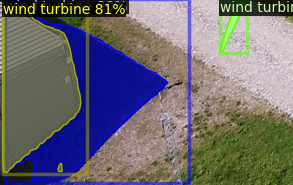

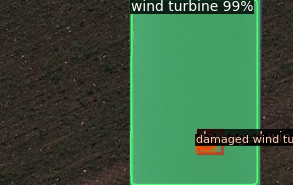

In [14]:
import matplotlib.pyplot as plt


dataset_dicts = get_sign_dicts('/content/drive/MyDrive/wind_turbine_dataset/val')
for d in random.sample(dataset_dicts, 2):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=wind_turbine_test1_metadata,
                   scale=0.5,
                  #  instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [15]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("wind_turbine_test1_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "wind_turbine_test1_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[12/29 11:56:12 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[12/29 11:56:12 d2.evaluation.coco_evaluation]: Trying to convert 'wind_turbine_test1_val' to COCO format ...
[12/29 11:56:12 d2.data.datasets.coco]: Converting annotations of dataset 'wind_turbine_test1_val' to COCO format ...)
[12/29 11:56:13 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[12/29 11:56:13 d2.data.datasets.coco]: Conversion finished, #images: 109, #annotations: 186
[12/29 11:56:13 d2.data.datasets.coco]: Caching COCO format annotations at './output/wind_turbine_test1_val_coco_format.json' ...
[12/29 11:56:13 d2.data.build]: Distribution of instances among all 2 categories:
|   category   | #instances   |   category    | #instances   |
|:------------:|:-------------|:-------------:|:-------------|
| wind turbine | 122          | damaged win.. | 64           |
|              |              |               |              |
|    total     | 18